In [63]:
!pip install geopy shapely
!pip install folium
!pip install osmnx
!pip install geopandas matplotlib contextily folium

In [64]:
import networkx as nx
import osmnx as ox
import numpy as np
import pandas as pd
from pyproj import Transformer
import os
import glob
from shapely.geometry import Point
from geopandas import GeoDataFrame
from geopy.distance import geodesic

In [65]:
#Creating a bbox with the dirving roads only from the centre of Leeds

leeds_centre = (53.8008, -1.5491)

dist = 600

north = geodesic(meters=dist).destination(leeds_centre, bearing=0).latitude
south = geodesic(meters=dist).destination(leeds_centre, bearing=180).latitude
east = geodesic(meters=dist).destination(leeds_centre, bearing=90).longitude
west = geodesic(meters=dist).destination(leeds_centre, bearing=270).longitude


bbox = (north, south, east, west)


G = ox.graph_from_bbox(north=bbox[0], south=bbox[1], east=bbox[2], west=bbox[3], network_type='drive')


/var/folders/jm/kdm_dw8123b0_rn021mc53f80000gn/T/ipykernel_38658/402290615.py:16: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G = ox.graph_from_bbox(north=bbox[0], south=bbox[1], east=bbox[2], west=bbox[3], network_type='drive')


In [66]:
#Constructed the bbox into a projected graph
G_proj = ox.project_graph(G)

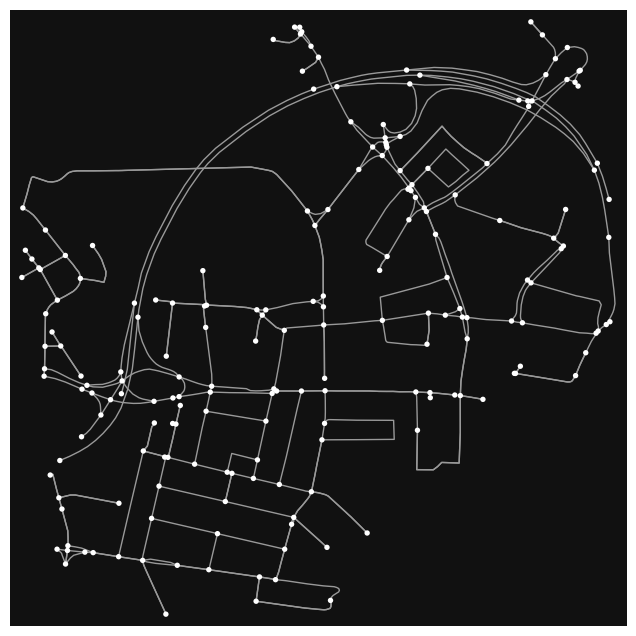

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [67]:
#plotting the projected graph to have a clear vision
ox.plot_graph(G_proj)

In [68]:
# Get node points
node_points = [Point(data['x'], data['y']) for _, data in G_proj.nodes(data=True)]

# Create a GeoDataFrame
gdf_nodes = GeoDataFrame({'geometry': node_points}, crs=G_proj.graph['crs'])

# Calculate the convex hull
convex_hull = gdf_nodes.unary_union.convex_hull

# Calculate area in square kilometers
area_km2 = convex_hull.area / 1e6
print(f"Area covered: {area_km2:} square kilometers")

Area covered: 1.0442041686344479 square kilometers


In [69]:
#Checking whether the graph is planar or not and give the counterexample for the argument
is_planar, counterexample = nx.check_planarity(
    G_proj, counterexample=True)
is_planar

False

In [70]:
counterexample

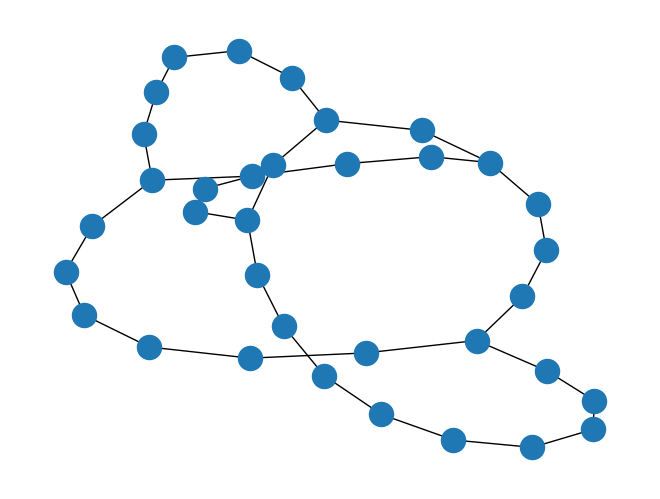

In [71]:
#Plotting the counterexample to show a planar graph
nx.draw(counterexample)

In [72]:
#Get the size of length for all pairs
lengths = dict(nx.all_pairs_dijkstra_path_length(G_proj, weight='length'))

# Find the spatial diameter with the max length
spatial_diameter = max(max(length.values()) for length in lengths.values())
print("Spatial Diameter of the Network:", spatial_diameter, "meters")

Spatial Diameter of the Network: 3807.405 meters


In [73]:
# Calculate the total length of all streets
total_length = sum(d['length'] for u, v, d in G_proj.edges(data=True))

# Count the total number of street segments
total_streets = len(G_proj.edges())

# Calculate the average street length
average_street_length = total_length / total_streets
print("Average Street Length:", average_street_length, "meters")

Average Street Length: 76.50442372881362 meters


In [74]:
#Get the total nodes of the projected graph
total_nodes = len(G_proj.nodes())
#Calculate the node density
node_density = total_nodes / area_km2

print(f"Node Density: {node_density} nodes per square kilometer")

Node Density: 188.66042285353606 nodes per square kilometer


In [75]:
#Add up all the values of lengths of the edges for the projected graph
total_edge_length = sum(nx.get_edge_attributes(G_proj, 'length').values())
#Calculate the edge density
edge_density = total_edge_length / area_km2

print(f"Total Edge Length: {total_edge_length} meters")
print(f"Edge Density: {edge_density} meters per square kilometer")

Total Edge Length: 27082.56600000002 meters
Edge Density: 25936.0830127858 meters per square kilometer


In [76]:
# Count intersections of nodes with degree > 1
intersections = sum(1 for node, degree in G.degree() if degree > 1)

# Calculate the intersection density
intersection_density = intersections / area_km2

print(f"Intersection Density: {intersection_density} intersections per square kilometer")

Intersection Density: 183.87208724811634 intersections per square kilometer


In [77]:
#Accessing the dataset with the corresponding columns
CRIMES_DIR = "Question_data"
USE_COLS = ['Reference Number', 'Grid Ref: Easting', 'Grid Ref: Northing']
#Concat all csv files into one dataframe
df = [pd.read_csv(csv_file, usecols=USE_COLS, encoding='latin1') \
             for path, subdir, _ in os.walk(CRIMES_DIR) \
             for csv_file in glob.glob(os.path.join(path, "*.csv"))]
accident_df = pd.concat(df, axis=0, ignore_index=True)
#Transfer the grid reference into lat and long
transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
accident_df['Longitude'], accident_df['Latitude'] = transformer.transform(accident_df['Grid Ref: Easting'].values,
                                                                          accident_df['Grid Ref: Northing'].values)
#Checking the total number of road accidents
print("Total no. of crimes loaded: {}".format(len(accident_df)))

Total no. of crimes loaded: 13851


In [78]:
#Transfer degree to km
accident_df['distance'] = ((accident_df['Latitude'] - leeds_centre[0])**2 + (accident_df['Longitude'] - leeds_centre[1])**2)**0.5 * 111 
# Filter accidents within 5 km radius
df_near_leeds = accident_df[accident_df['distance'] <= 5]
#Show the table of filtered accidents
df_near_leeds

,Reference Number,Grid Ref: Easting,Grid Ref: Northing,Longitude,Latitude,distance
9,6111836,429149,431736,-1.559123,53.781142,2.449332
10,6120357,428760,432723,-1.564934,53.790034,2.125387
11,6121501,431451,435823,-1.523774,53.817741,3.382135
12,6130451,427555,433891,-1.583120,53.800597,3.776327
18,6140252,430783,438603,-1.533642,53.842766,4.964175
...,...,...,...,...,...,...
13838,4CU0586,431435,431610,-1.524445,53.779877,3.589352
13845,4CV0902,430343,431175,-1.541059,53.776032,2.890568
13846,4CV0902,430343,431175,-1.541059,53.776032,2.890568
13847,4CV1387,427748,436446,-1.579961,53.823550,4.255727


In [79]:
from sklearn.cluster import DBSCAN
#Getting the coordinates with the values of lat and long
coords = df_near_leeds[['Latitude', 'Longitude']].values
#Put the coordinates and use DBscan to plot a graph with different cluster labels 
db = DBSCAN(eps=0.001, min_samples=10).fit(coords)
labels = db.labels_

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Removing noise label
print(f"Number of clusters: {n_clusters}") #Get the total number of clusters except the outliers
print("Cluster labels:", np.unique(labels)) #Printing all cluster labels

df_near_leeds['cluster'] = labels

# Filter noise points
df_clusters = df_near_leeds[df_near_leeds['cluster'] != -1]

# Add cluster to the dataframe
df_near_leeds['cluster'] = db
#Calculating the coordinates of cluster label with the most recorded road accidents
most_accidents_cluster = df_clusters['cluster'].value_counts().idxmax()
cluster_center = df_clusters[df_clusters['cluster'] == most_accidents_cluster][['Latitude', 'Longitude']].mean()
print(f"Cluster center with most accidents: {cluster_center}")

Number of clusters: 111
Cluster labels: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110]
Cluster center with most accidents: Latitude     53.796905
Longitude    -1.540826
dtype: float64


/var/folders/jm/kdm_dw8123b0_rn021mc53f80000gn/T/ipykernel_38658/96783076.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_near_leeds['cluster'] = labels
/var/folders/jm/kdm_dw8123b0_rn021mc53f80000gn/T/ipykernel_38658/96783076.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_near_leeds['cluster'] = db


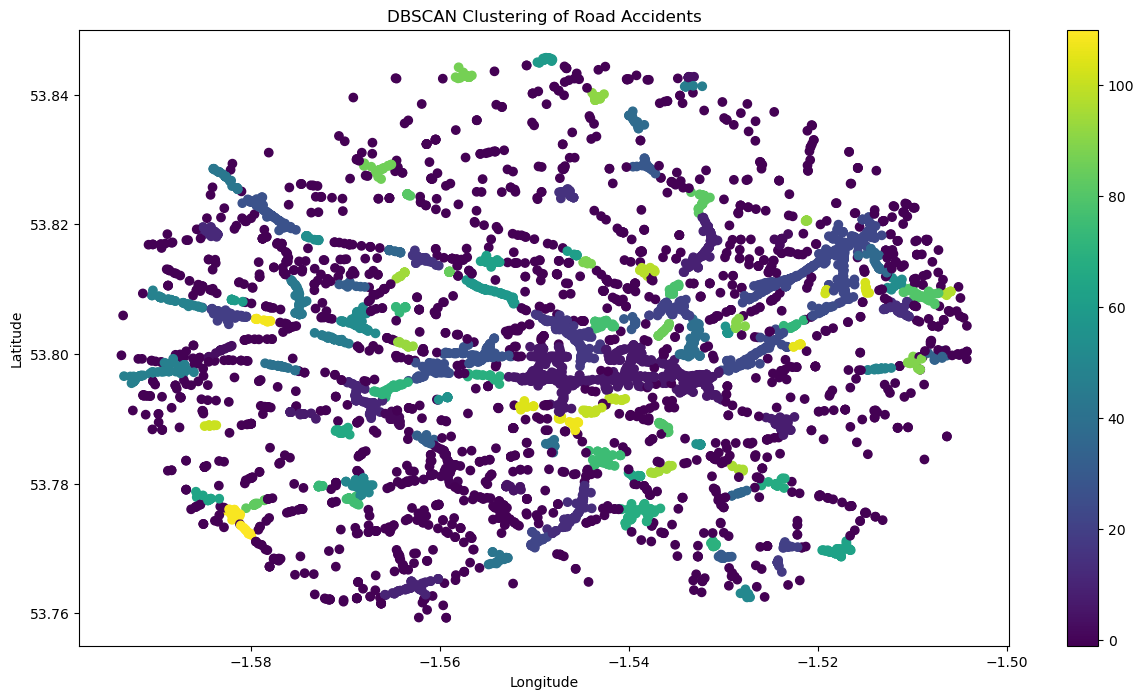

In [80]:
import matplotlib.pyplot as plt

# Plotting the graph that used DBScan
plt.figure(figsize=(15, 8))
scatter = plt.scatter(df_near_leeds['Longitude'], df_near_leeds['Latitude'], c=labels, cmap='viridis', label=labels)
plt.title('DBSCAN Clustering of Road Accidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(scatter)
plt.show()

In [81]:
#Getting the number of all recorded road accidents to each cluster labels
unique_labels, counts = np.unique(labels, return_counts=True)
cluster_info_np = dict(zip(unique_labels, counts))

In [82]:
import itertools
#Calculating the sum of distances of all shortest path for all node pairs (the actual distance)
total_distance = 0
for node1, node2 in itertools.combinations(G.nodes(), 2):
    try:
        path_length = nx.shortest_path_length(G, source=node1, target=node2, weight='length')
        total_distance += path_length
    except nx.NetworkXNoPath:
        continue

print("Total distance of shortest paths for all pairs:", total_distance)

Total distance of shortest paths for all pairs: 19510213.969999928


In [83]:
import itertools
from geopy.distance import geodesic
#Calculating the sum of geodesic distances for all nodes (the direct distance)
total_direct_distance = 0
for node1, node2 in itertools.combinations(G.nodes(), 2):
    # Access attributes directly from nodes dictionary
    coords_1 = (G.nodes[node1]['y'], G.nodes[node1]['x'])  # Ensure nodes[node1] is used correctly
    coords_2 = (G.nodes[node2]['y'], G.nodes[node2]['x'])

    # Calculate geodesic distance
    distance = geodesic(coords_1, coords_2).meters
    total_direct_distance += distance

print("Total direct distance:", total_direct_distance)

Total direct distance: 10941184.645350188


In [84]:
#Printing the result of the average circuitry
print(f"Average Circuitry: {total_distance/total_direct_distance}")

Average Circuitry: 1.7831902670878905


In [86]:
#Printing all the characteristics for the results section in the report
print(f"Spatial Diameter of the Network:", spatial_diameter, "meters")
print(f"Average Street Length:", average_street_length, "meters")
print(f"Node Density: {node_density} nodes per square kilometer")
print(f"Edge Density: {edge_density} meters per square kilometer")
print(f"Average Circuitry: {total_distance/total_direct_distance}")
print(f"Intersection Density: {intersection_density} intersections per square kilometer")

Spatial Diameter of the Network: 3807.405 meters
Average Street Length: 76.50442372881362 meters
Node Density: 188.66042285353606 nodes per square kilometer
Edge Density: 25936.0830127858 meters per square kilometer
Average Circuitry: 1.7831902670878905
Intersection Density: 183.87208724811634 intersections per square kilometer
